In [1]:
!nvidia-smi
%env CUDA_VISIBLE_DEVICES=0
%env CUDA_VISIBLE_DEVICES

Tue Jun  8 10:55:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Tesla V1...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   31C    P0    43W / 300W |      3MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA Tesla V1...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

'0'

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import torchaudio
import torch
import torch.nn.functional as F
import torch.nn as nn
from tqdm.notebook import tqdm
from glob import glob
from datetime import datetime
import numpy as np
from WaveNetTTS.model import WaveNet
from matplotlib import pyplot as plt
import os
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
random.seed(12)
os.environ['PYTHONHASHSEED'] = str(12)
np.random.seed(12)
torch.manual_seed(12)
torch.cuda.manual_seed(12)

In [5]:
sp_freq = 4000
seq_len = 4000
bins = 128
batch_size = 58
channels = 256
kernel_size = 2
dilation_depth = 9
blocks = 2
condition_size = 256

MuLawEncoding = torchaudio.transforms.MuLawEncoding(quantization_channels=bins)
MuLawDecoding = torchaudio.transforms.MuLawDecoding(bins)
Resample = torchaudio.transforms.Resample(16000, sp_freq)

hugging_face_model = 'bert-base-uncased'#'distilbert-base-uncased'#
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', hugging_face_model)

Using cache found in /zhome/22/c/137477/.cache/torch/hub/huggingface_pytorch-transformers_master


In [6]:
model = WaveNet(quantization_bins=bins, kernel_size=kernel_size, channels=channels, dilation_depth=dilation_depth, blocks=blocks, condition_size=condition_size, global_condition=True, local_condition=True)
model = model.to(device)

Using cache found in /zhome/22/c/137477/.cache/torch/hub/huggingface_pytorch-transformers_master


In [7]:
chkpt = torch.load('LJ_speech_WaveNet_28-04-2021-seq_L4000-bins128-batch58-C256-k2-dil9b2-cs256-sp_freq4000.pt')

In [8]:
model.load_state_dict(chkpt['model'])
model.eval()

WaveNet(
  (causal_layers): ModuleList(
    (0): ResidualLayer(
      (conv_fg): Conv1d(256, 512, kernel_size=(2,), stride=(1,))
      (conv_1x1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (gc_layer_fg): Linear(in_features=256, out_features=512, bias=True)
      (lc_layer_fg): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    )
    (1): ResidualLayer(
      (conv_fg): Conv1d(256, 512, kernel_size=(2,), stride=(1,), dilation=(2,))
      (conv_1x1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (gc_layer_fg): Linear(in_features=256, out_features=512, bias=True)
      (lc_layer_fg): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    )
    (2): ResidualLayer(
      (conv_fg): Conv1d(256, 512, kernel_size=(2,), stride=(1,), dilation=(4,))
      (conv_1x1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (gc_layer_fg): Linear(in_features=256, out_features=512, bias=True)
      (lc_layer_fg): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
    )
    (3): ResidualL

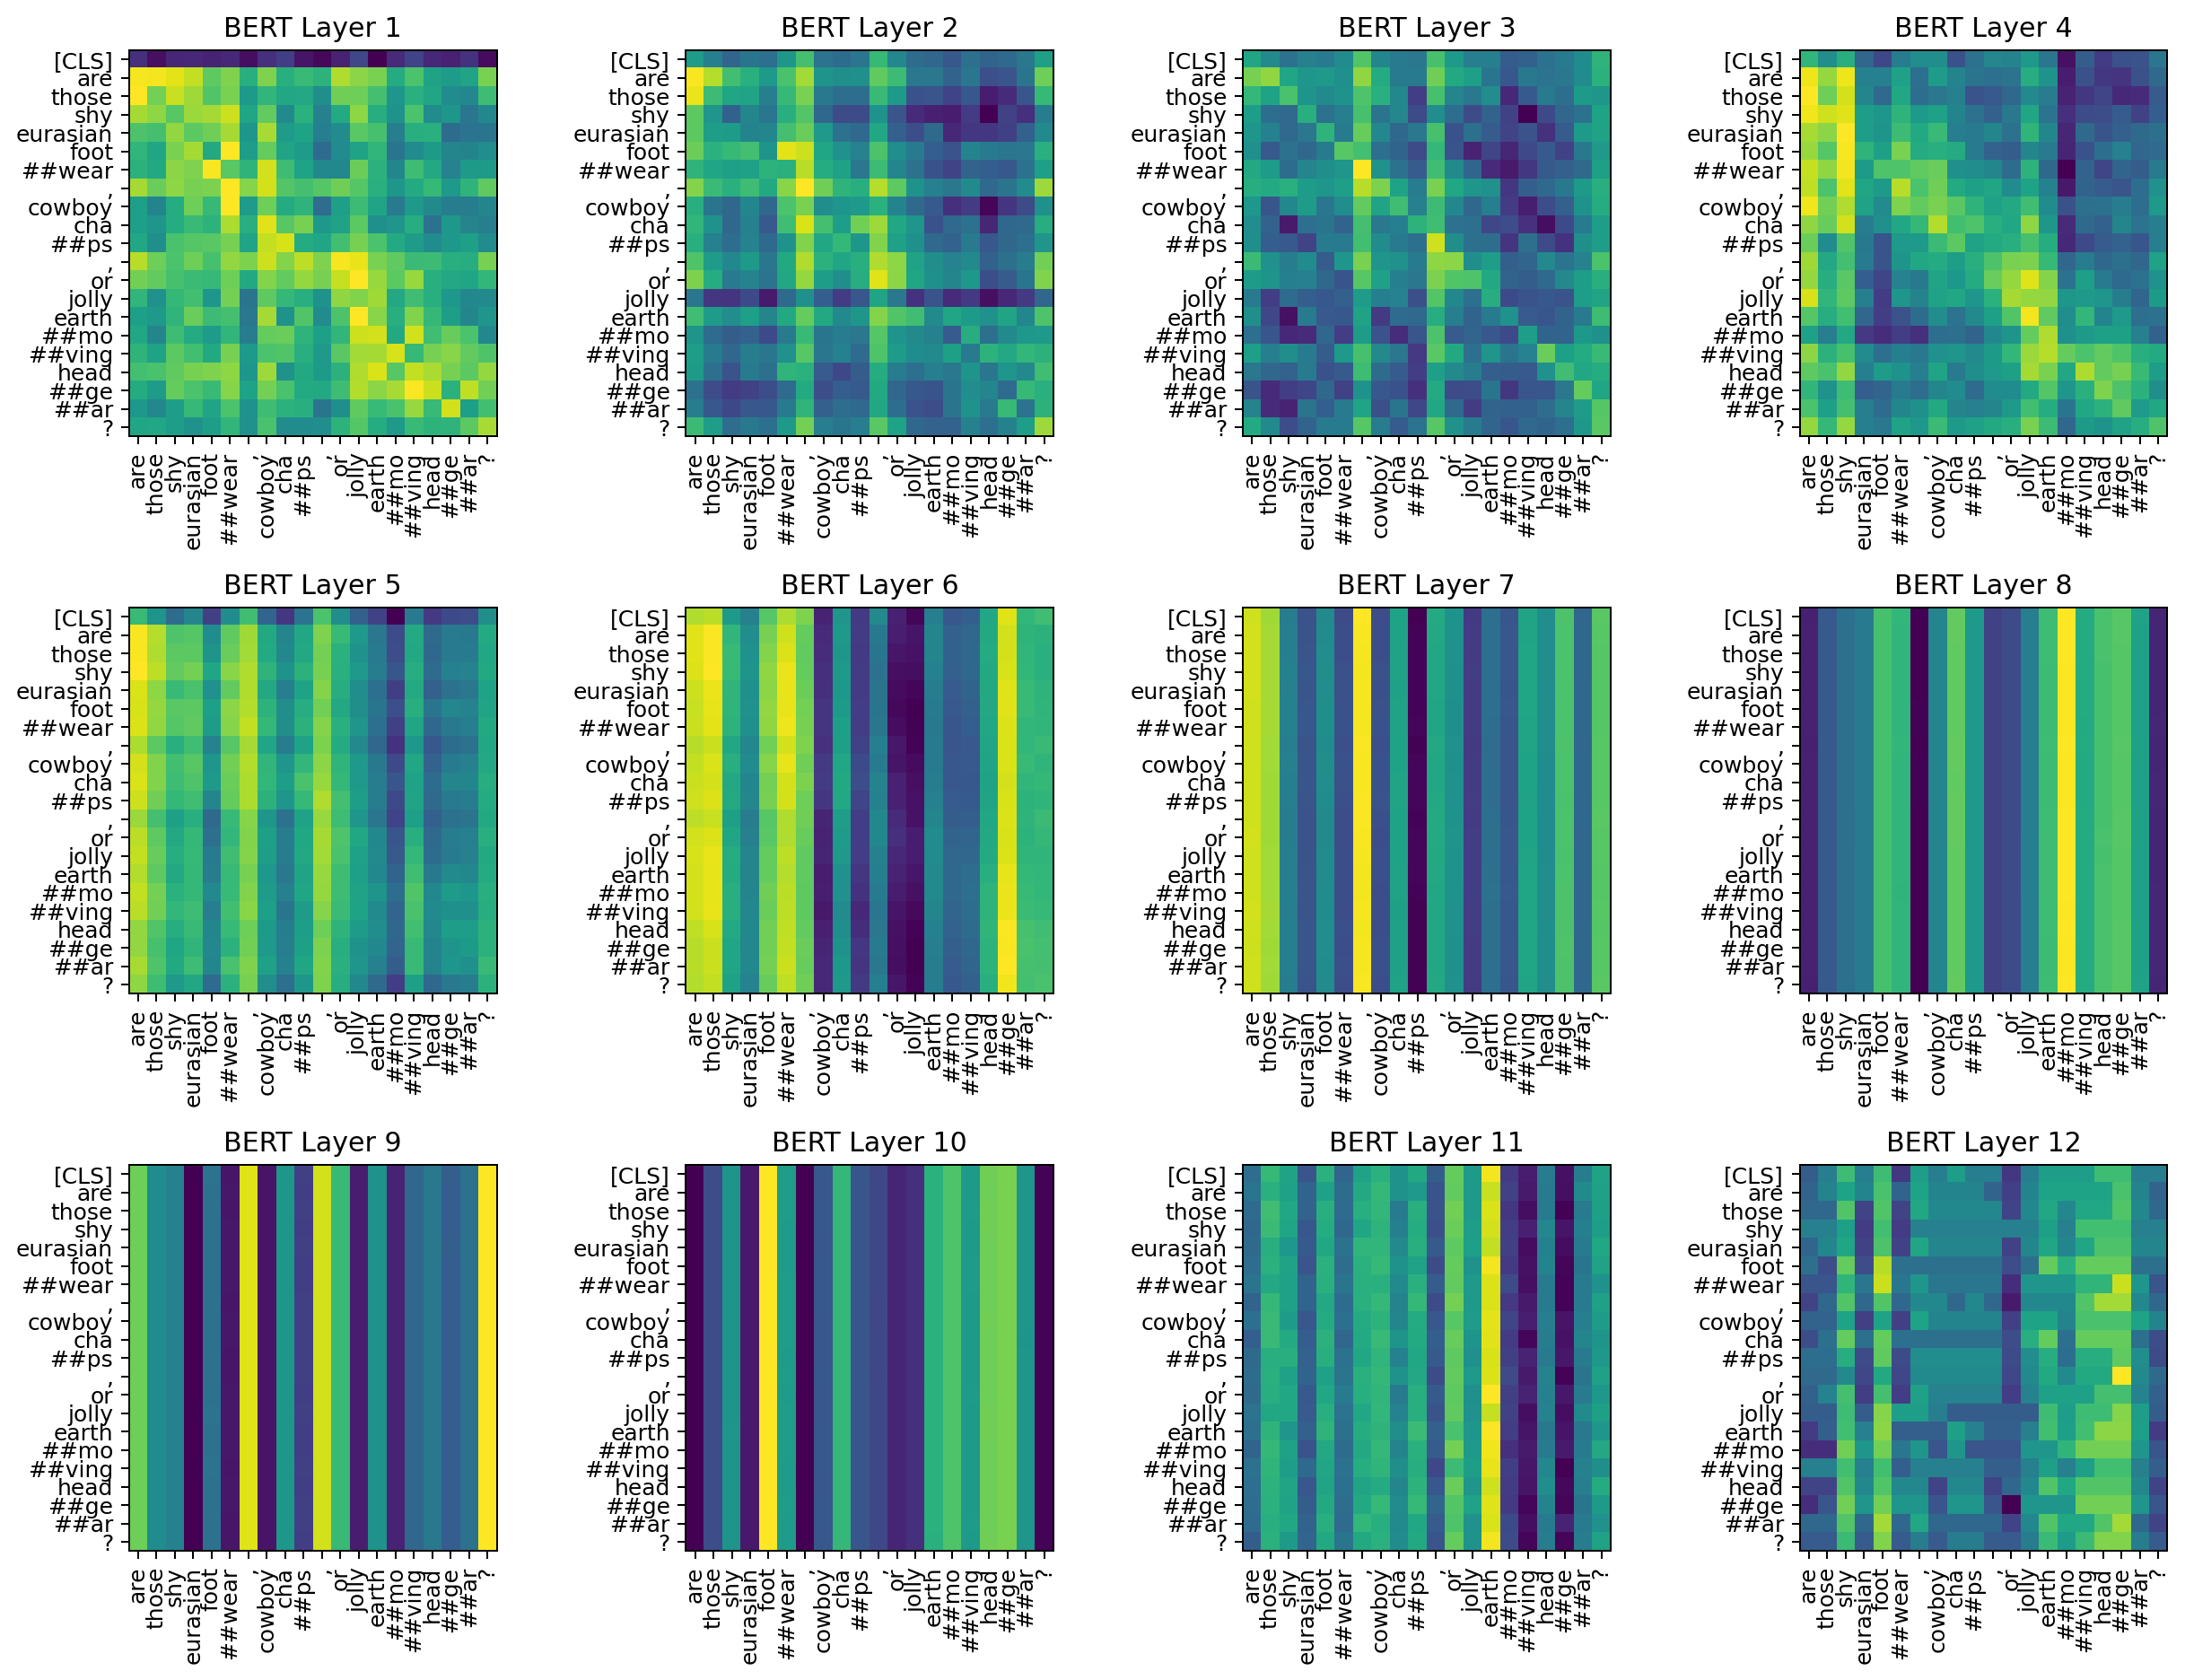

In [14]:
fig, axs = plt.subplots(3,4,figsize=(4*3.5,3*3.5), dpi=180)
for i in range(3):
    for j in range(4):
        query_maps = []
        key_maps = []
        value_maps = []
        hooks = [
                model.sentence_embedding.bert.encoder.layer[i*4+j].attention.self.query.register_forward_hook(
                  lambda self, input, output: query_maps.append(output[0])
                ),
                model.sentence_embedding.bert.encoder.layer[i*4+j].attention.self.key.register_forward_hook(
                  lambda self, input, output: key_maps.append(output[0])
                ),
                model.sentence_embedding.bert.encoder.layer[i*4+j].attention.self.value.register_forward_hook(
                  lambda self, input, output: value_maps.append(output[0])
                )
        ]
        transcript = "Are those shy Eurasian footwear, cowboy chaps, or jolly earthmoving headgear?"
        #question = "who was the head of the college of pontiffs?"
        #passage = "Until 104 BC, the pontifex maximus held the sole power in appointing members to the other priesthoods in the college."
        with torch.no_grad():
            model.eval()
            tokens = tokenizer(transcript, return_attention_mask=False, return_token_type_ids=False, return_tensors='pt', padding=True)['input_ids'].to(device)

            #Feed into sentence embedding class
            model.sentence_embedding(tokens)
        for hook in hooks:
            hook.remove()

        attn_toks = []
        attn_maps = []
        attention_scores = torch.matmul(query_maps[0], key_maps[0].transpose(-1, -2))
        #attention_scores = torch.matmul(query_layer[:,64*5:64*(5+1)], key_layer[:,64*5:64*(5+1)].transpose(-1, -2)) # LOOK AT ONE HEAD ONLY
        attention_scores = attention_scores / np.sqrt(model.sentence_embedding.bert.encoder.layer[-1].attention.self.attention_head_size)
        attention_probs = torch.nn.LogSoftmax(dim=-1)(attention_scores)
        attn_maps.append(attention_probs)
        attn_toks.append([tokenizer.decode(pq) for pq in tokens[0]])


        #for attn_map, attn_tok, ax, ttl in zip(attn_maps, attn_toks, [axs[0][i], axs[1][i]], ['q attention layer: ', 'p attention layer: ']):
        axs[i,j].imshow(attn_maps[0].cpu()[:-1,1:-1], interpolation='none', aspect='equal', cmap='viridis')
        axs[i,j].set_xticks(np.arange(len(attn_toks[0][1:-1])))
        axs[i,j].set_yticks(np.arange(len(attn_toks[0][:-1])))
        axs[i,j].set_xticklabels(attn_toks[0][1:-1])
        axs[i,j].set_yticklabels(attn_toks[0][:-1])
        axs[i,j].set_title('BERT Layer '+str(i*4+j+1))
        for tick in axs[i,j].get_xticklabels():
            tick.set_rotation(90)
plt.tight_layout()
plt.savefig('BERT_maps.pdf', dpi=180, bbox_inches='tight')